SIZE OF THE RAW DATASET (5110, 11)
SUMMARY OF THE RAW DATASET
         gender          age  hypertension  heart_disease ever_married  \
count     5110  5110.000000   5110.000000    5110.000000         5110   
unique       3          NaN           NaN            NaN            2   
top     Female          NaN           NaN            NaN          Yes   
freq      2994          NaN           NaN            NaN         3353   
mean       NaN    43.226614      0.097456       0.054012          NaN   
std        NaN    22.612647      0.296607       0.226063          NaN   
min        NaN     0.080000      0.000000       0.000000          NaN   
25%        NaN    25.000000      0.000000       0.000000          NaN   
50%        NaN    45.000000      0.000000       0.000000          NaN   
75%        NaN    61.000000      0.000000       0.000000          NaN   
max        NaN    82.000000      1.000000       1.000000          NaN   

       work_type Residence_type  avg_glucose_level          

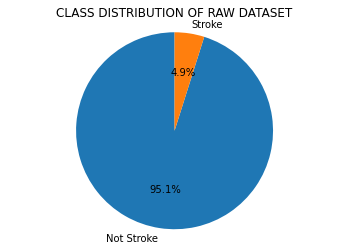

0    4861
1     249
Name: stroke, dtype: int64


In [1]:
import pandas as pd
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split

dataset = pd.read_csv("healthcare-dataset-stroke-data.csv", index_col="id")

features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
            'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']
target = 'stroke'

# split into input and output elements
X = dataset[features]
Y = dataset[target]

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)

print("> SIZE OF THE RAW DATASET", dataset.shape)
print("> SUMMARY OF THE RAW DATASET\n", dataset.describe(include='all'))

# pie chart showing
fig, ax = pyplot.subplots()
ax.pie(dataset[target].value_counts(), labels=["Not Stroke", "Stroke"], autopct='%1.1f%%', startangle=90)
ax.axis('equal')
ax.set_title("> CLASS DISTRIBUTION OF RAW DATASET")
pyplot.show()
print(dataset[target].value_counts())

# Data Cleaning

## Identify Columns That Have Very Few Values

In [2]:
# number of unique values in each column
n_uniques = X.nunique()

In [9]:
# report the column and the number of unique values for each column
print("> SIZE OF THE RAW DATASET:", dataset.shape)
print("{:<20}{:>10}{:>15}".format("FEATURE", "N_UNIQUE", "PERCENTAGE"))
print("----------------------------------------------")
for col in features:
    percentage = n_uniques[col] / X.shape[0] * 100
    print("{:<20}{:>10}{:>15.1f}%".format(col, n_uniques[col], percentage))

> SIZE OF THE RAW DATASET: (5110, 11)
FEATURE               N_UNIQUE     PERCENTAGE
----------------------------------------------
gender                       3            0.1%
age                        104            2.0%
hypertension                 2            0.0%
heart_disease                2            0.0%
ever_married                 2            0.0%
work_type                    5            0.1%
Residence_type               2            0.0%
avg_glucose_level         3979           77.9%
bmi                        418            8.2%
smoking_status               4            0.1%


In [7]:
# report the columns that has less than 1% number of unique values and these unique values
print("{:<20}{}".format("FEATURE", "UNIQUE VALUES"))
print("----------------------------------------------")
for col in features:
    percentage = n_uniques[col]/X.shape[0] * 100
    if percentage < 1:
        print("{:<20}{}".format(col, X[col].unique()))

FEATURE             UNIQUE VALUES
----------------------------------------------
gender              ['Male' 'Female' 'Other']
hypertension        [0 1]
heart_disease       [1 0]
ever_married        ['Yes' 'No']
work_type           ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type      ['Urban' 'Rural']
smoking_status      ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


## Remove Rows That Contain Duplicate Data

In [10]:
print("> SIZE OF THE RAW DATASET:", dataset.shape)
# calculate duplicates
dups = dataset.duplicated()
# report if there are any duplicated
print("Duplicate rows? >>>", dups.any())
# list all duplicate rows
print(dataset[dups])
# drop_duplicate rows (if any)
dataset.drop_duplicates(inplace=True)
print("> SIZE AFTER REMOVING DUPLICATE ROWS:", dataset.shape)

> SIZE OF THE RAW DATASET: (5110, 11)
Duplicate rows? >>> False
Empty DataFrame
Columns: [gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status, stroke]
Index: []
> SIZE AFTER REMOVING DUPLICATE ROWS: (5110, 11)


## Outliers Detection

In [45]:
# determine categorical and numerical features by percentage of unique values
categorical_ix = []
numerical_ix = []
for col in X.columns:
    percentage = n_uniques[col]/X.shape[0] * 100
    if percentage < 1:
        categorical_ix.append(col)
    else:
        numerical_ix.append(col)
print("CATEGORICAL FEATURES DETECTED:", categorical_ix)
print("NUMERICAL FEATURES DETECTED  :", numerical_ix)

CATEGORICAL FEATURES DETECTED: ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
NUMERICAL FEATURES DETECTED  : ['age', 'avg_glucose_level', 'bmi']


> HISTOGRAM ON NUMERICAL FEATURES:


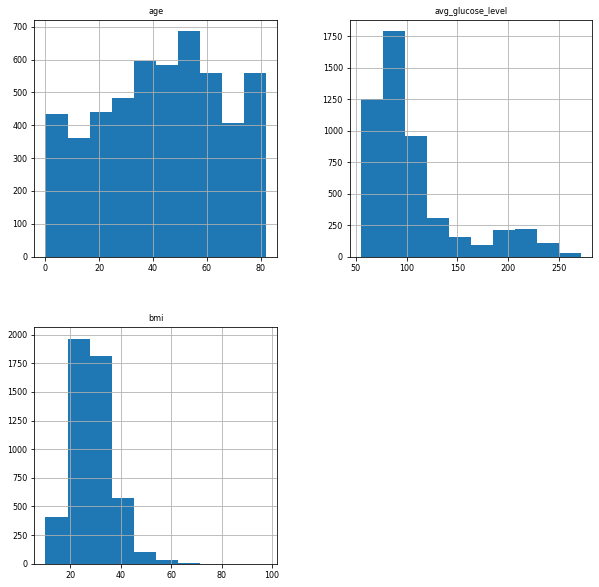

> BOX AND WHISKER PLOT ON NUMERICAL FEATURES:


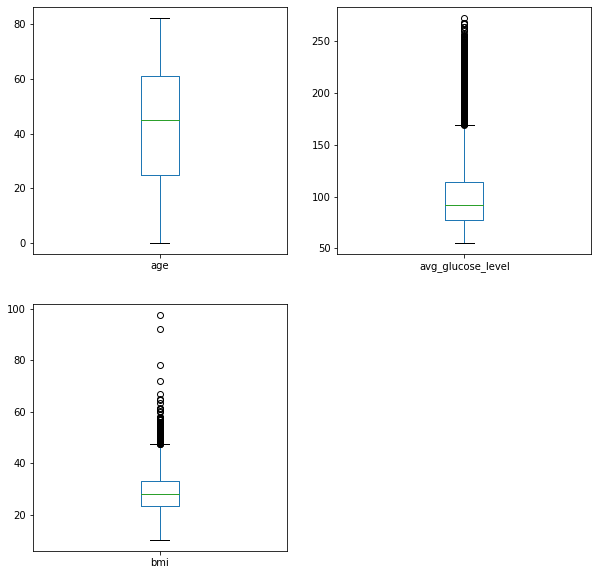

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


In [15]:
# histogram plot
print("> HISTOGRAM ON NUMERICAL FEATURES:")
fig = dataset[numerical_ix].hist(xlabelsize=8, ylabelsize=8, figsize=(10, 10))
[x.title.set_size(8) for x in fig.ravel()]
pyplot.show()

# box and whisker plot
print("> BOX AND WHISKER PLOT ON NUMERICAL FEATURES:")
dataset[numerical_ix].plot(kind='box', subplots=True, layout=(2,2), figsize=(10, 10))
pyplot.show()

# # scatter plot matrix
# scatter_matrix(dataset)
# pyplot.show()

# summarize
dataset[numerical_ix].describe()

By looking at the table and by research domain specific knowledge, we infer:

* *age* feature has outliers, where min value should be greater than 0.08
* *bmi* feature has outliers, where max value should not be far greater than 35

### Option 1: Identify Outlier With Standard Deviation

From histogram, we assume *bmi* have near-Gaussian distribution. So we can apply Standard Deviation method in defining outliers.

UPPER BOUND FOR BMI IS NOW: 52.455437100835155
LOWER BOUND FOR AGE IS NOW: 1
> SIZE OF THE RAW DATASET: (5110, 11)
> SIZE IF REMOVE OUTLIERS: (5009, 11)


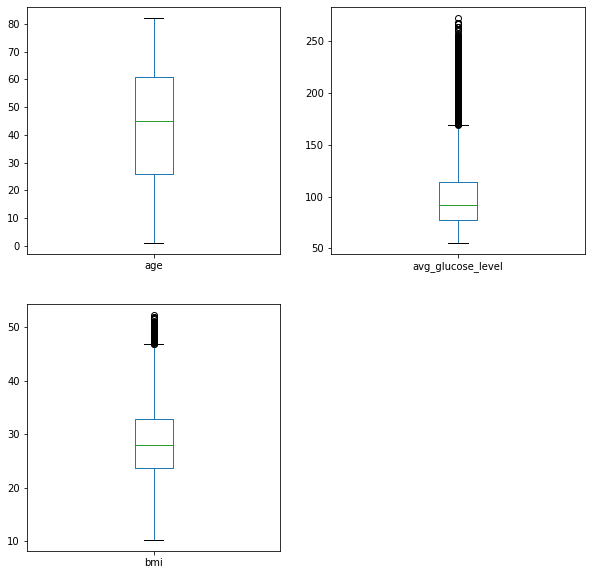

In [46]:
bmi_mean, bmi_std = dataset["bmi"].mean(), dataset["bmi"].std()
# define outliers outside 3 factor of std from mean
cut_off = bmi_std * 3
bmi_upper = bmi_mean + cut_off
print("UPPER BOUND FOR BMI IS NOW:", bmi_upper)

age_lower = 1
print("LOWER BOUND FOR AGE IS NOW:", age_lower)

# identify non-outlier indexes
outlier = (dataset["bmi"] > bmi_upper) | (dataset["age"] < age_lower)
outlier_removed = outlier == False

print("> SIZE OF THE RAW DATASET:", dataset.shape)
print("> SIZE IF REMOVE OUTLIERS:", dataset[outlier_removed].shape)

# box and whisker plot
dataset[outlier_removed][numerical_ix].plot(kind='box', subplots=True, layout=(2,2), figsize=(10,10))
pyplot.show()


### Option 2: Identify Outlier With Quantile Range

UPPER BOUND FOR BMI IS NOW: 71.5
LOWER BOUND FOR AGE IS NOW: 1
> SIZE OF THE RAW DATASET: (5110, 11)
> SIZE IF REMOVE OUTLIERS: (5063, 11)


age                     AxesSubplot(0.125,0.536818;0.352273x0.343182)
avg_glucose_level    AxesSubplot(0.547727,0.536818;0.352273x0.343182)
bmi                        AxesSubplot(0.125,0.125;0.352273x0.343182)
dtype: object

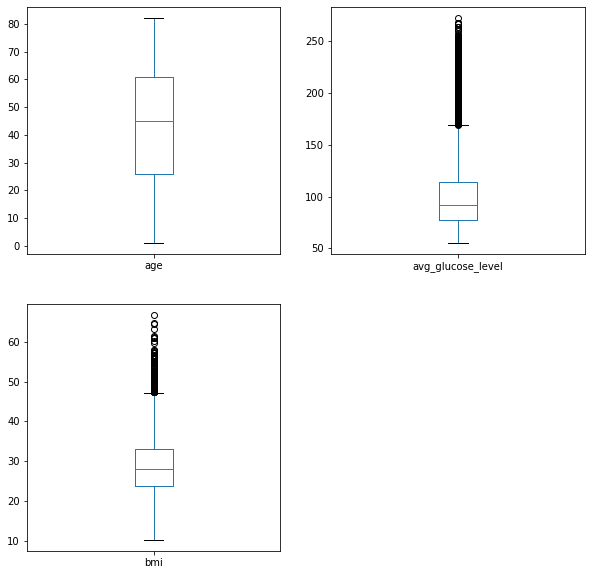

In [41]:
q25, q75 = dataset['bmi'].quantile(0.25), dataset['bmi'].quantile(0.75)
iqr = q75 - q25
cut_off = iqr * 4
bmi_upper = q75 + cut_off
print("UPPER BOUND FOR BMI IS NOW:", bmi_upper)

age_lower = 1
print("LOWER BOUND FOR AGE IS NOW:", age_lower)

# identify non-outlier indexes
outlier = (dataset["bmi"] > bmi_upper) | (dataset["age"] < age_lower)
outlier_removed = outlier == False

print("> SIZE OF THE RAW DATASET:", dataset.shape)
print("> SIZE IF REMOVE OUTLIERS:", dataset[outlier_removed].shape)

# box and whisker plot
dataset[outlier_removed][numerical_ix].plot(kind='box', subplots=True, layout=(2,2), figsize=(10,10))
pyplot.show()

### Option 3: Identify Outliers With Local Outlier Factor


In [47]:
# identify outliers in the training dataset
lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train[numerical_ix])
# select all rows that are not outliers
outlier_removed = yhat != 1
X_train, y_train = X_train[outlier_removed], y_train[outlier_removed]
print(X_train.head(10))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

11.979999999999999
44.620000000000005
Empty DataFrame
Columns: [age, avg_glucose_level, bmi]
Index: []
